# Phase 2: Anomaly Detection (Cheating & Smurfing)

This notebook implements a comprehensive system for detecting anomalous player behaviour using:
1. **Phase 1 Residuals**: Performance significantly better than expected rating
2. **Move-Level Features**: Accuracy, consistency, engine correlation
3. **Autoencoder**: Unsupervised anomaly detection
4. **Supervised Classifier**: Using labeled cheating data
5. **Hybrid Approach**: Combining all signals for robust detection

## Learning Problem

**Objective**: Detect anomalous player behaviour indicative of cheating (using chess engines) or smurfing (hiding true skill) using a hybrid unsupervised-supervised approach.

**Problem Type**: Anomaly Detection - Hybrid (Unsupervised + Supervised Binary Classification)

**Input**: Player-game features capturing performance patterns including move accuracy metrics (top-1/3/5 engine matches, error/blunder rates), behavioural patterns (consistency, streaks, temporal changes), and game context (rating, result, game phase statistics). We extract 24 features per player-game instance from two datasets: "Spotting Cheaters" (binary labels per move) and "Cheating Tuesdays" (Stockfish engine analysis with move timing).

**Output**: A hybrid anomaly score (0-1) combining unsupervised reconstruction error and supervised probability, with three-tier decision thresholds: BAN (≥85% - high confidence cheating), REVIEW (60-84% - suspicious behaviour requiring manual review), and NORMAL (<60% - legitimate play).

**Challenge**: This is a highly imbalanced and noisy problem. Genuine strong players occasionally play "perfect" games resembling engines, while sophisticated cheaters only use engines selectively to avoid detection. Additionally, we lack ground truth for many suspicious cases, and available labels may be unreliable. The model must distinguish between exceptional human play and systematic computer assistance while maintaining high recall (catching real cheaters) without excessive false positives (banning legitimate players).

**Approach**: We implement a **hybrid detection system** that combines complementary strengths:

1. **Autoencoder (Unsupervised)**: Trained exclusively on 160K+ truly clean games to learn the "normal" distribution of human play patterns. High reconstruction error indicates deviation from typical human behaviour, capturing cheaters who exhibit unnatural consistency or inhuman pattern combinations not seen in training.

2. **Classifier (Supervised)**: A deep neural network (128→64→32→16 neurons) trained on 48K balanced examples (50% cheating, 50% clean) with known labels. This learns explicit cheating signatures from labeled data, such as excessive top-engine move rates, suspicious timing patterns, and accuracy inconsistencies.

3. **Hybrid Fusion**: We combine both scores using an optimized weighted average: `hybrid_score = α·classifier + (1-α)·autoencoder`, where α≈0.70 is tuned via grid search on validation data. This fusion leverages both approaches - the autoencoder catches novel/unknown cheating patterns while the classifier provides strong discrimination on known signatures.

**Dataset Integration**: By combining "Spotting Cheaters" (provides fine-grained per-move labels and pattern features) with "Cheating Tuesdays" (provides engine-computed accuracy metrics and timing data), we create a richer feature space that captures both behavioural patterns and move quality, enabling more robust detection across different cheating strategies.

In [56]:
! pip install pandas numpy matplotlib seaborn scikit-learn torch scipy tqdm python-chess

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)
from sklearn.ensemble import IsolationForest, RandomForestClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Load Datasets

## Load Spotting Cheaters Dataset

Much more balanced dataset

In [58]:
# Load the Spotting Cheaters dataset
print("=" * 70)
print("LOADING 'SPOTTING CHEATERS' DATASET")
print("=" * 70)

cheaters_df = pd.read_csv('data/Spotting Cheaters : Chess cheating dataset.csv')
print(f"Total games: {len(cheaters_df):,}")
print(f"\nColumns: {list(cheaters_df.columns)}")
print(f"\nFirst row sample:")
print(cheaters_df.head(1).T)

# Check for missing values
print(f"\nMissing values:")
print(cheaters_df.isnull().sum())

LOADING 'SPOTTING CHEATERS' DATASET
Total games: 48,933

Columns: ['Liste cheat white', 'Liste cheat black', 'Game', 'Elo White', 'Elo Black', 'Score']

First row sample:
                                                                   0
Liste cheat white       00000000001111101010111010100110000001001111
Liste cheat black        0000000000111001000000001100100000000111000
Game               1. d4 e6 2. c4 d5 3. Nc3 Be7 4. Nf3 Nf6 5. Bf4...
Elo White                                                       1001
Elo Black                                                         -1
Score                                                        1/2-1/2

Missing values:
Liste cheat white    0
Liste cheat black    0
Game                 1
Elo White            0
Elo Black            0
Score                0
dtype: int64


In [59]:
# Parse binary cheat labels to categorize games
def count_cheating_moves(label_str):
    """Count the number of 1s (cheating moves) in binary string"""
    if pd.isna(label_str) or label_str == '':
        return 0
    return str(label_str).count('1')

def get_total_moves(label_str):
    """Get total number of moves from binary string length"""
    if pd.isna(label_str) or label_str == '':
        return 0
    return len(str(label_str))

# Count cheating moves for each player
cheaters_df['white_cheat_moves'] = cheaters_df['Liste cheat white'].apply(count_cheating_moves)
cheaters_df['black_cheat_moves'] = cheaters_df['Liste cheat black'].apply(count_cheating_moves)
cheaters_df['white_total_moves'] = cheaters_df['Liste cheat white'].apply(get_total_moves)
cheaters_df['black_total_moves'] = cheaters_df['Liste cheat black'].apply(get_total_moves)

# Calculate cheating percentage
cheaters_df['white_cheat_pct'] = (cheaters_df['white_cheat_moves'] / 
                                   cheaters_df['white_total_moves'].replace(0, 1) * 100)
cheaters_df['black_cheat_pct'] = (cheaters_df['black_cheat_moves'] / 
                                   cheaters_df['black_total_moves'].replace(0, 1) * 100)

# Categorize games (threshold: >5% cheating moves = cheater)
CHEAT_THRESHOLD = 5.0  # Percentage
cheaters_df['white_is_cheater'] = cheaters_df['white_cheat_pct'] > CHEAT_THRESHOLD
cheaters_df['black_is_cheater'] = cheaters_df['black_cheat_pct'] > CHEAT_THRESHOLD

# Game categories
truly_clean = (~cheaters_df['white_is_cheater']) & (~cheaters_df['black_is_cheater'])
one_sided_white = cheaters_df['white_is_cheater'] & (~cheaters_df['black_is_cheater'])
one_sided_black = (~cheaters_df['white_is_cheater']) & cheaters_df['black_is_cheater']
both_cheating = cheaters_df['white_is_cheater'] & cheaters_df['black_is_cheater']

print("\n" + "=" * 70)
print("GAME CATEGORIZATION")
print("=" * 70)
print(f"Truly clean games (both players clean): {truly_clean.sum():,}")
print(f"One-sided cheating (white cheating): {one_sided_white.sum():,}")
print(f"One-sided cheating (black cheating): {one_sided_black.sum():,}")
print(f"Both players cheating: {both_cheating.sum():,}")
print(f"\nTotal one-sided cheating: {(one_sided_white.sum() + one_sided_black.sum()):,}")

# Statistics on cheating intensity
print(f"\n" + "=" * 70)
print("CHEATING INTENSITY STATISTICS")
print("=" * 70)
cheaters_only = cheaters_df[cheaters_df['white_is_cheater'] | cheaters_df['black_is_cheater']]
print(f"\nWhite cheaters (when cheating):")
print(f"  Mean: {cheaters_df[cheaters_df['white_is_cheater']]['white_cheat_pct'].mean():.1f}%")
print(f"  Median: {cheaters_df[cheaters_df['white_is_cheater']]['white_cheat_pct'].median():.1f}%")
print(f"  Range: {cheaters_df[cheaters_df['white_is_cheater']]['white_cheat_pct'].min():.1f}% - {cheaters_df[cheaters_df['white_is_cheater']]['white_cheat_pct'].max():.1f}%")

print(f"\nBlack cheaters (when cheating):")
print(f"  Mean: {cheaters_df[cheaters_df['black_is_cheater']]['black_cheat_pct'].mean():.1f}%")
print(f"  Median: {cheaters_df[cheaters_df['black_is_cheater']]['black_cheat_pct'].median():.1f}%")
print(f"  Range: {cheaters_df[cheaters_df['black_is_cheater']]['black_cheat_pct'].min():.1f}% - {cheaters_df[cheaters_df['black_is_cheater']]['black_cheat_pct'].max():.1f}%")


GAME CATEGORIZATION
Truly clean games (both players clean): 11,090
One-sided cheating (white cheating): 13,740
One-sided cheating (black cheating): 17,631
Both players cheating: 6,472

Total one-sided cheating: 31,371

CHEATING INTENSITY STATISTICS

White cheaters (when cheating):
  Mean: 39.3%
  Median: 38.7%
  Range: 5.1% - 93.6%

Black cheaters (when cheating):
  Mean: 39.2%
  Median: 38.7%
  Range: 5.1% - 92.3%


In [60]:
import chess
import chess.pgn
from io import StringIO

def parse_pgn_game(pgn_string):
    """
    Parse a PGN string and return game info.
    Returns: (moves_san, total_plies, result)
    """
    try:
        # Clean up the PGN string
        pgn_string = str(pgn_string).strip()
        
        # Parse moves (format: '1. e4 e5 2. Nf3 Nc6 ...')
        moves_san = []
        tokens = pgn_string.split()
        
        result = None
        for token in tokens:
            # Skip move numbers (e.g., '1.', '2.')
            if token.endswith('.'):
                continue
            # Check for result
            if token in ['1-0', '0-1', '1/2-1/2', '*']:
                result = token
                break
            # Add move
            moves_san.append(token)
        
        return moves_san, len(moves_san), result
    except Exception as e:
        print(f"Error parsing PGN: {e}")
        return [], 0, None

# Test on first game
print("Testing PGN parser on first game...")
test_pgn = cheaters_df.iloc[0]['Game']
moves, plies, result = parse_pgn_game(test_pgn)
print(f"\nPGN: {test_pgn[:100]}...")
print(f"Parsed {plies} moves")
print(f"First 10 moves: {moves[:10]}")
print(f"Result: {result}")

Testing PGN parser on first game...

PGN: 1. d4 e6 2. c4 d5 3. Nc3 Be7 4. Nf3 Nf6 5. Bf4 O-O 6. e3 a6 7. h3 dxc4 8. Bxc4 b5 9. Bb3 Bb7 10. Bc2...
Parsed 87 moves
First 10 moves: ['d4', 'e6', 'c4', 'd5', 'Nc3', 'Be7', 'Nf3', 'Nf6', 'Bf4', 'O-O']
Result: 1-0


In [61]:
from tqdm import tqdm

def extract_player_features_from_game(row, color='white'):
    """
    Extract features for a single player from a game.
    Uses the binary cheat labels to understand patterns.
    """
    try:
        # Get cheat label and move count
        cheat_label = str(row[f'Liste cheat {color}']).strip()
        moves_san, total_plies, result = parse_pgn_game(row['Game'])
        
        # Separate moves by color
        if color == 'white':
            player_moves_idx = list(range(0, len(moves_san), 2))  # 0, 2, 4, ...
        else:
            player_moves_idx = list(range(1, len(moves_san), 2))  # 1, 3, 5, ...
        
        num_moves = len(player_moves_idx)
        if num_moves == 0 or len(cheat_label) < num_moves:
            return None
        
        # Parse cheat label for this player's moves
        cheat_moves = [int(cheat_label[i]) if i < len(cheat_label) else 0 
                       for i in range(num_moves)]
        
        # Calculate features
        features = {}
        features['game_id'] = row.name  # Use index as game_id
        features['color'] = color
        features['rating'] = row[f'Elo {color.capitalize()}']
        features['num_moves'] = num_moves
        
        # Cheating statistics
        num_cheat = sum(cheat_moves)
        features['cheat_move_count'] = num_cheat
        features['cheat_percentage'] = (num_cheat / num_moves * 100) if num_moves > 0 else 0
        features['is_cheater'] = features['cheat_percentage'] > CHEAT_THRESHOLD
        
        # Pattern features: streak analysis
        max_cheat_streak = 0
        current_streak = 0
        max_clean_streak = 0
        clean_streak = 0
        
        for is_cheat in cheat_moves:
            if is_cheat:
                current_streak += 1
                max_cheat_streak = max(max_cheat_streak, current_streak)
                clean_streak = 0
            else:
                clean_streak += 1
                max_clean_streak = max(max_clean_streak, clean_streak)
                current_streak = 0
        
        features['max_cheat_streak'] = max_cheat_streak
        features['max_clean_streak'] = max_clean_streak
        
        # Temporal patterns: opening vs middlegame vs endgame
        opening_moves = min(10, num_moves)
        middlegame_start = opening_moves
        middlegame_end = max(middlegame_start, num_moves - 10)
        
        features['opening_cheat_pct'] = (sum(cheat_moves[:opening_moves]) / opening_moves * 100) if opening_moves > 0 else 0
        
        if middlegame_end > middlegame_start:
            mid_moves = cheat_moves[middlegame_start:middlegame_end]
            features['middlegame_cheat_pct'] = (sum(mid_moves) / len(mid_moves) * 100) if mid_moves else 0
        else:
            features['middlegame_cheat_pct'] = 0
        
        if num_moves > middlegame_end:
            end_moves = cheat_moves[middlegame_end:]
            features['endgame_cheat_pct'] = (sum(end_moves) / len(end_moves) * 100) if end_moves else 0
        else:
            features['endgame_cheat_pct'] = 0
        
        # Consistency metrics (variance in cheating behaviour)
        # Split game into 5-move windows and calculate variance
        window_size = 5
        window_cheat_rates = []
        for i in range(0, num_moves, window_size):
            window = cheat_moves[i:i+window_size]
            if window:
                window_cheat_rates.append(sum(window) / len(window))
        
        if len(window_cheat_rates) > 1:
            features['cheat_consistency'] = np.std(window_cheat_rates)
        else:
            features['cheat_consistency'] = 0
        
        # Game phase transition: did cheating increase/decrease over time?
        if num_moves >= 20:
            first_half = cheat_moves[:num_moves//2]
            second_half = cheat_moves[num_moves//2:]
            first_half_pct = sum(first_half) / len(first_half) * 100
            second_half_pct = sum(second_half) / len(second_half) * 100
            features['cheat_increase'] = second_half_pct - first_half_pct
        else:
            features['cheat_increase'] = 0
        
        # Result-based features
        if result == '1-0':
            features['won'] = 1 if color == 'white' else 0
        elif result == '0-1':
            features['won'] = 0 if color == 'white' else 1
        else:
            features['won'] = 0.5  # Draw
        
        return features
        
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# Extract features for all players in all games
print("\n" + "=" * 70)
print("EXTRACTING PLAYER FEATURES")
print("=" * 70)
print("This will take a few minutes...\n")

all_player_features = []

for idx, row in tqdm(cheaters_df.iterrows(), total=len(cheaters_df), desc="Processing games"):
    # Extract features for white
    white_features = extract_player_features_from_game(row, 'white')
    if white_features:
        all_player_features.append(white_features)
    
    # Extract features for black
    black_features = extract_player_features_from_game(row, 'black')
    if black_features:
        all_player_features.append(black_features)

# Convert to DataFrame
spotting_cheaters_features = pd.DataFrame(all_player_features)

print(f"\n✓ Extracted features for {len(spotting_cheaters_features):,} player-game instances")
print(f"  - Clean players: {(~spotting_cheaters_features['is_cheater']).sum():,}")
print(f"  - Cheaters: {spotting_cheaters_features['is_cheater'].sum():,}")
print(f"\nFeatures: {list(spotting_cheaters_features.columns)}")


EXTRACTING PLAYER FEATURES
This will take a few minutes...



Processing games: 100%|██████████| 48933/48933 [00:03<00:00, 15091.07it/s]



✓ Extracted features for 97,865 player-game instances
  - Clean players: 53,578
  - Cheaters: 44,287

Features: ['game_id', 'color', 'rating', 'num_moves', 'cheat_move_count', 'cheat_percentage', 'is_cheater', 'max_cheat_streak', 'max_clean_streak', 'opening_cheat_pct', 'middlegame_cheat_pct', 'endgame_cheat_pct', 'cheat_consistency', 'cheat_increase', 'won']


In [62]:
# Visualize feature distributions
print("\n" + "=" * 70)
print("FEATURE DISTRIBUTION ANALYSIS")
print("=" * 70)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

features_to_plot = [
    'cheat_percentage', 'max_cheat_streak', 'max_clean_streak',
    'opening_cheat_pct', 'middlegame_cheat_pct', 'endgame_cheat_pct',
    'cheat_consistency', 'cheat_increase', 'num_moves'
]

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    clean_data = spotting_cheaters_features[~spotting_cheaters_features['is_cheater']][feature]
    cheat_data = spotting_cheaters_features[spotting_cheaters_features['is_cheater']][feature]
    
    # Plot distributions
    ax.hist(clean_data, bins=50, alpha=0.6, label='Clean', color='green', density=True)
    ax.hist(cheat_data, bins=50, alpha=0.6, label='Cheater', color='red', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'{feature}\nClean: μ={clean_data.mean():.2f}, Cheat: μ={cheat_data.mean():.2f}')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('spotting_cheaters_features.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate Cohen's d for feature separation
print("\n" + "=" * 70)
print("FEATURE DISCRIMINABILITY (Cohen's d)")
print("=" * 70)
print("Cohen's d > 0.8 = Good separation")
print("Cohen's d > 1.2 = Excellent separation\n")

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group2.mean() - group1.mean()) / pooled_std if pooled_std > 0 else 0

for feature in features_to_plot:
    clean_data = spotting_cheaters_features[~spotting_cheaters_features['is_cheater']][feature]
    cheat_data = spotting_cheaters_features[spotting_cheaters_features['is_cheater']][feature]
    d = cohens_d(clean_data, cheat_data)
    print(f"{feature:30s}: {d:6.3f}  {'✓' if abs(d) > 0.8 else ''}")


FEATURE DISTRIBUTION ANALYSIS



FEATURE DISCRIMINABILITY (Cohen's d)
Cohen's d > 0.8 = Good separation
Cohen's d > 1.2 = Excellent separation

cheat_percentage              :  2.869  ✓
max_cheat_streak              :  1.369  ✓
max_clean_streak              : -2.461  ✓
opening_cheat_pct             :  0.000  
middlegame_cheat_pct          :  2.500  ✓
endgame_cheat_pct             :  2.706  ✓
cheat_consistency             :  4.130  ✓
cheat_increase                :  1.830  ✓
num_moves                     :  0.085  


In [63]:
# Create truly clean dataset for autoencoder training
print("\n" + "=" * 70)
print("CREATING CLEAN DATASET FOR AUTOENCODER")
print("=" * 70)

# Filter for truly clean players (0% cheating)
truly_clean_players = spotting_cheaters_features[
    (spotting_cheaters_features['cheat_percentage'] == 0) &
    (spotting_cheaters_features['num_moves'] >= 15)  # Minimum game length
].copy()

print(f"Truly clean players: {len(truly_clean_players):,}")
print(f"Clean games available for autoencoder training: {truly_clean_players['game_id'].nunique():,}")

# Additional quality filters
# Remove suspiciously high-rated players (might be engines themselves)
MAX_CLEAN_RATING = 2800
truly_clean_players = truly_clean_players[truly_clean_players['rating'] < MAX_CLEAN_RATING]

print(f"After rating filter (<{MAX_CLEAN_RATING}): {len(truly_clean_players):,}")

# Summary statistics
print(f"\nClean player statistics:")
print(f"  Rating range: {truly_clean_players['rating'].min():.0f} - {truly_clean_players['rating'].max():.0f}")
print(f"  Mean rating: {truly_clean_players['rating'].mean():.0f}")
print(f"  Median game length: {truly_clean_players['num_moves'].median():.0f} moves")


CREATING CLEAN DATASET FOR AUTOENCODER
Truly clean players: 50,491
Clean games available for autoencoder training: 41,293
After rating filter (<2800): 50,491

Clean player statistics:
  Rating range: -1 - 2616
  Mean rating: 1693
  Median game length: 40 moves


In [64]:
from sklearn.utils import resample

# Create balanced dataset for supervised learning
print("\n" + "=" * 70)
print("CREATING BALANCED DATASET FOR CLASSIFIER")
print("=" * 70)

# Separate cheaters and clean players
cheater_players = spotting_cheaters_features[
    spotting_cheaters_features['is_cheater']
].copy()

clean_players = spotting_cheaters_features[
    ~spotting_cheaters_features['is_cheater']
].copy()

print(f"\nOriginal class distribution:")
print(f"  Cheaters: {len(cheater_players):,}")
print(f"  Clean: {len(clean_players):,}")
print(f"  Ratio: 1:{len(clean_players)/len(cheater_players):.1f}")

# Balance using undersampling (keep all cheaters, sample clean players)
TARGET_RATIO = 3  # Clean:Cheater ratio
n_clean_samples = min(len(clean_players), len(cheater_players) * TARGET_RATIO)

clean_players_balanced = resample(
    clean_players,
    n_samples=n_clean_samples,
    random_state=42,
    replace=False
)

# Combine into balanced dataset
balanced_dataset = pd.concat([cheater_players, clean_players_balanced], ignore_index=True)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"\nBalanced class distribution:")
print(f"  Cheaters: {balanced_dataset['is_cheater'].sum():,}")
print(f"  Clean: {(~balanced_dataset['is_cheater']).sum():,}")
print(f"  Ratio: 1:{(~balanced_dataset['is_cheater']).sum() / balanced_dataset['is_cheater'].sum():.1f}")

print(f"\n✓ Created balanced dataset with {len(balanced_dataset):,} samples")


CREATING BALANCED DATASET FOR CLASSIFIER

Original class distribution:
  Cheaters: 44,287
  Clean: 53,578
  Ratio: 1:1.2

Balanced class distribution:
  Cheaters: 44,287
  Clean: 53,578
  Ratio: 1:1.2

✓ Created balanced dataset with 97,865 samples


In [65]:
# Define feature set for models
print("\n" + "=" * 70)
print("PREPARING FEATURES FOR MODELS")
print("=" * 70)

# Select features for model training (exclude metadata)
feature_columns = [
    'cheat_percentage',
    'max_cheat_streak',
    'max_clean_streak',
    'opening_cheat_pct',
    'middlegame_cheat_pct',
    'endgame_cheat_pct',
    'cheat_consistency',
    'cheat_increase',
    'num_moves',
    'rating',
    'won'
]

print(f"\nFeature set: {len(feature_columns)} features")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

# Check for missing values
print(f"\nMissing values check:")
for col in feature_columns:
    missing = balanced_dataset[col].isna().sum()
    if missing > 0:
        print(f"  {col}: {missing} missing")
    
# Fill any missing values with median
for col in feature_columns:
    if balanced_dataset[col].isna().any():
        median_val = balanced_dataset[col].median()
        balanced_dataset[col] = balanced_dataset[col].fillna(median_val)
        print(f"  Filled {col} with median: {median_val:.2f}")

print(f"\n✓ All features ready for modeling")


PREPARING FEATURES FOR MODELS

Feature set: 11 features
   1. cheat_percentage
   2. max_cheat_streak
   3. max_clean_streak
   4. opening_cheat_pct
   5. middlegame_cheat_pct
   6. endgame_cheat_pct
   7. cheat_consistency
   8. cheat_increase
   9. num_moves
  10. rating
  11. won

Missing values check:

✓ All features ready for modeling


# Cheating Tuesday Dataset

In [ ]:
import os
from pathlib import Path

# moves.csv was split into 2 smaller files to be pushed to github
def load_moves_csv(data_dir):
    """
    Load moves.csv, handling both merged and split versions.
    
    Args:
        data_dir: Path to data directory
        
    Returns:
        pd.DataFrame: Moves data
    """
    moves_file = os.path.join(data_dir, 'moves.csv')
    part1_file = os.path.join(data_dir, 'moves_part1.csv')
    part2_file = os.path.join(data_dir, 'moves_part2.csv')
    
    # Check if merged file exists
    if os.path.exists(moves_file):
        print(f"Loading merged moves.csv...")
        return pd.read_csv(moves_file)
    
    # Check if split files exist
    elif os.path.exists(part1_file) and os.path.exists(part2_file):
        print(f"Loading split moves files...")
        print(f"  - Reading {Path(part1_file).name}...")
        df1 = pd.read_csv(part1_file)
        print(f"    Loaded {len(df1):,} rows")
        
        print(f"  - Reading {Path(part2_file).name}...")
        df2 = pd.read_csv(part2_file)
        print(f"    Loaded {len(df2):,} rows")
        
        print(f"  - Merging...")
        df_merged = pd.concat([df1, df2], ignore_index=True)
        print(f"    Total: {len(df_merged):,} rows")
        
        # Optionally save merged version for future use
        save_merged = input("Save merged file? (y/n): ").lower() == 'y'
        if save_merged:
            print(f"  - Saving to {Path(moves_file).name}...")
            df_merged.to_csv(moves_file, index=False)
            print(f"    ✓ Saved for future use")
        
        return df_merged
    
    else:
        raise FileNotFoundError(
            f"Cannot find moves data in {data_dir}.\n"
            f"Expected either:\n"
            f"  - {moves_file}\n"
            f"  OR\n"
            f"  - {part1_file} AND {part2_file}"
        )

print("✓ Moves CSV loader defined")

✓ Moves CSV loader defined


In [6]:
# ============================================================================
# LOAD CHEATING TUESDAYS DATASET (ENGINE ANALYSIS)
# ============================================================================

print("\n" + "=" * 70)
print("LOADING CHEATING TUESDAYS DATASET")
print("=" * 70)

tt_dir = 'data/Cheating Tuesdays: Chess.com TT & Stockfish 16/'

# Load games
tt_games = pd.read_csv(os.path.join(tt_dir, 'analysed_games.csv'))
print(f"✓ Games: {len(tt_games):,}")

# Load moves (handles both merged and split versions)
tt_moves = load_moves_csv(tt_dir)
print(f"✓ Moves: {len(tt_moves):,}")

print(f"\nMove features: move_accuracy, is_top1/3/5, move_time, is_error, is_blunder")


LOADING CHEATING TUESDAYS DATASET
✓ Games: 161,203
Loading split moves files...
  - Reading moves_part1.csv...
    Loaded 7,057,451 rows
  - Reading moves_part2.csv...
    Loaded 7,057,452 rows
  - Merging...
    Total: 14,114,903 rows
✓ Moves: 14,114,903

Move features: move_accuracy, is_top1/3/5, move_time, is_error, is_blunder


In [67]:
# ============================================================================
# EXTRACT FEATURES FROM CHEATING TUESDAYS
# ============================================================================

print("\n" + "=" * 70)
print("EXTRACTING CHEATING TUESDAYS FEATURES")
print("=" * 70)

from tqdm import tqdm

# Index games for fast lookup
tt_games_indexed = tt_games.set_index('game_id')

# Group moves by (game_id, username)
grouped_moves = tt_moves.groupby(['game_id', 'username'])

tt_features_list = []

for (game_id, username), player_moves in tqdm(grouped_moves, desc="Processing CT data"):
    if len(player_moves) == 0:
        continue
    
    # Compute features
    features = {
        'game_id': game_id,
        'username': username,
        'num_moves': len(player_moves),
        
        # Core features (matching Spotting Cheaters)
        'avg_move_accuracy': player_moves['move_accuracy'].mean(),
        'std_move_accuracy': player_moves['move_accuracy'].std(),
        'top1_rate': player_moves['is_top1'].mean(),
        'top3_rate': player_moves['is_top3'].mean(),
        'top5_rate': player_moves['is_top5'].mean(),
        'error_rate': player_moves['is_error'].mean(),
        'blunder_rate': player_moves['is_blunder'].mean(),
        'accuracy_consistency': 1 - (player_moves['move_accuracy'].std() / 100) if player_moves['move_accuracy'].std() > 0 else 1,
        
        # Time features (exclusive to CT)
        'avg_move_time': player_moves['move_time'].mean(),
        'std_move_time': player_moves['move_time'].std(),
        'fast_move_rate': (player_moves['move_time'] < 5).mean(),
        'fast_accurate_rate': ((player_moves['move_time'] < 5) & (player_moves['move_accuracy'] > 90)).mean(),
        
        # Endgame
        'endgame_accuracy': player_moves[player_moves['is_endgame']]['move_accuracy'].mean() if 'is_endgame' in player_moves.columns and player_moves['is_endgame'].any() else np.nan,
        
        # Cheating pattern features (approximate from accuracy)
        # Since CT doesn't have per-move labels, estimate from top1 rate
        'cheat_percentage': player_moves['is_top1'].mean() * 100,  # Proxy
        'max_cheat_streak': 0,  # Cannot compute without labels
        'max_clean_streak': 0,
        'opening_cheat_pct': player_moves['is_top1'].iloc[:min(10, len(player_moves))].mean() * 100 if len(player_moves) >= 10 else 0,
        'middlegame_cheat_pct': np.nan,  # Approximate
        'endgame_cheat_pct': player_moves[player_moves['is_endgame']]['is_top1'].mean() * 100 if 'is_endgame' in player_moves.columns and player_moves['is_endgame'].any() else 0,
        'cheat_consistency': player_moves['is_top1'].std(),  # Variance in engine match rate
        'cheat_increase': 0,  # Cannot compute
    }
    
    # Add game info
    try:
        game_info = tt_games_indexed.loc[game_id]
        features['rating'] = game_info['WhiteElo'] if username == game_info['username_white'] else game_info['BlackElo']
        features['won'] = 0.5  # Unknown (no result info)
        features['is_cheater'] = game_info['isBlocked_white'] if username == game_info['username_white'] else game_info['isBlocked_black']
        features['dataset_source'] = 'cheating_tuesdays'
    except KeyError:
        continue
    
    tt_features_list.append(features)

tt_features_df = pd.DataFrame(tt_features_list)

print(f"\n✓ Extracted {len(tt_features_df):,} player-game instances")
print(f"  Cheaters: {tt_features_df['is_cheater'].sum():,} ({tt_features_df['is_cheater'].mean()*100:.1f}%)")


EXTRACTING CHEATING TUESDAYS FEATURES


Processing CT data: 100%|██████████| 321612/321612 [02:48<00:00, 1913.04it/s]



✓ Extracted 321,612 player-game instances
  Cheaters: 2,055 (0.6%)


# Combine Both Datasets

In [68]:
# ============================================================================
# COMBINE SPOTTING CHEATERS + CHEATING TUESDAYS DATASETS
# ============================================================================

print("\n" + "=" * 70)
print("COMBINING BOTH DATASETS")
print("=" * 70)

# ============================================================================
# 1. UNIFY FEATURE COLUMNS
# ============================================================================

# Define ALL possible features
all_feature_columns = [
    # Core features (both datasets)
    'cheat_percentage',
    'max_cheat_streak',
    'max_clean_streak',
    'opening_cheat_pct',
    'middlegame_cheat_pct',
    'endgame_cheat_pct',
    'cheat_consistency',
    'cheat_increase',
    'num_moves',
    'rating',
    'won',
    
    # Accuracy features (both)
    'avg_move_accuracy',
    'std_move_accuracy',
    'top1_rate',
    'top3_rate',
    'top5_rate',
    'error_rate',
    'blunder_rate',
    'accuracy_consistency',
    
    # Time features (CT only, will be NaN for SC)
    'avg_move_time',
    'std_move_time',
    'fast_move_rate',
    'fast_accurate_rate',
    'endgame_accuracy',
]

print(f"Unified feature set: {len(all_feature_columns)} features")

# ============================================================================
# 2. ADD MISSING FEATURES TO SPOTTING CHEATERS
# ============================================================================

print("\nAdding CT-exclusive features to Spotting Cheaters...")

# Time features (missing in SC)
for feat in ['avg_move_time', 'std_move_time', 'fast_move_rate', 'fast_accurate_rate']:
    if feat not in spotting_cheaters_features.columns:
        spotting_cheaters_features[feat] = np.nan

# Accuracy features (missing in SC)
for feat in ['avg_move_accuracy', 'std_move_accuracy', 'top1_rate', 'top3_rate', 'top5_rate', 
             'error_rate', 'blunder_rate', 'accuracy_consistency', 'endgame_accuracy']:
    if feat not in spotting_cheaters_features.columns:
        # Derive from cheat_percentage (heuristic)
        if feat == 'avg_move_accuracy':
            spotting_cheaters_features[feat] = 100 - spotting_cheaters_features['cheat_percentage']
        elif feat == 'top1_rate':
            spotting_cheaters_features[feat] = spotting_cheaters_features['cheat_percentage'] / 100
        elif feat in ['error_rate', 'blunder_rate']:
            spotting_cheaters_features[feat] = spotting_cheaters_features['cheat_percentage'] / 200  # Estimate
        else:
            spotting_cheaters_features[feat] = np.nan

spotting_cheaters_features['dataset_source'] = 'spotting_cheaters'

print(f"✓ Spotting Cheaters now has {len(spotting_cheaters_features.columns)} columns")

# ============================================================================
# 3. ADD MISSING FEATURES TO CHEATING TUESDAYS
# ============================================================================

print("\nAdding SC-exclusive features to Cheating Tuesdays...")

# Pattern features (approximate from available data)
for feat in ['cheat_percentage', 'max_cheat_streak', 'max_clean_streak', 
             'opening_cheat_pct', 'middlegame_cheat_pct', 'endgame_cheat_pct',
             'cheat_consistency', 'cheat_increase']:
    if feat not in tt_features_df.columns:
        if feat == 'cheat_percentage':
            tt_features_df[feat] = tt_features_df['top1_rate'] * 100  # Proxy
        elif feat == 'opening_cheat_pct':
            tt_features_df[feat] = tt_features_df.get('opening_cheat_pct', 0)
        else:
            tt_features_df[feat] = 0  # Cannot compute without per-move labels

# Ensure all columns exist
for feat in all_feature_columns:
    if feat not in tt_features_df.columns:
        tt_features_df[feat] = np.nan

print(f"✓ Cheating Tuesdays now has {len(tt_features_df.columns)} columns")

# ============================================================================
# 4. COMBINE DATASETS
# ============================================================================

print("\nCombining datasets...")

# Select only relevant columns
spotting_cheaters_subset = spotting_cheaters_features[all_feature_columns + ['is_cheater', 'dataset_source']].copy()
tt_subset = tt_features_df[all_feature_columns + ['is_cheater', 'dataset_source']].copy()

# Combine
combined_df = pd.concat([spotting_cheaters_subset, tt_subset], ignore_index=True)

print(f"\n✓ Combined dataset:")
print(f"  Total samples: {len(combined_df):,}")
print(f"  From Spotting Cheaters: {(combined_df['dataset_source'] == 'spotting_cheaters').sum():,}")
print(f"  From Cheating Tuesdays: {(combined_df['dataset_source'] == 'cheating_tuesdays').sum():,}")
print(f"  Total cheaters: {combined_df['is_cheater'].sum():,} ({combined_df['is_cheater'].mean()*100:.1f}%)")
print(f"  Features: {len(all_feature_columns)}")

# ============================================================================
# 5. HANDLE MISSING VALUES (SMART IMPUTATION)
# ============================================================================

print("\n" + "=" * 70)
print("HANDLING MISSING VALUES")
print("=" * 70)

# Strategy: Fill NaNs with dataset-specific medians
for feat in all_feature_columns:
    # Fill SC NaNs with CT median
    sc_mask = (combined_df['dataset_source'] == 'spotting_cheaters') & combined_df[feat].isna()
    if sc_mask.any():
        ct_median = combined_df[combined_df['dataset_source'] == 'cheating_tuesdays'][feat].median()
        if pd.notna(ct_median):
            combined_df.loc[sc_mask, feat] = ct_median
            print(f"  Filled {sc_mask.sum():>6} SC NaNs in '{feat:<25}' with CT median: {ct_median:.3f}")
    
    # Fill CT NaNs with SC median
    ct_mask = (combined_df['dataset_source'] == 'cheating_tuesdays') & combined_df[feat].isna()
    if ct_mask.any():
        sc_median = combined_df[combined_df['dataset_source'] == 'spotting_cheaters'][feat].median()
        if pd.notna(sc_median):
            combined_df.loc[ct_mask, feat] = sc_median
            print(f"  Filled {ct_mask.sum():>6} CT NaNs in '{feat:<25}' with SC median: {sc_median:.3f}")

# Final cleanup: fill remaining NaNs with global median
remaining_nans = combined_df[all_feature_columns].isna().sum().sum()
if remaining_nans > 0:
    combined_df[all_feature_columns] = combined_df[all_feature_columns].fillna(combined_df[all_feature_columns].median())
    print(f"\n  Filled {remaining_nans} remaining NaNs with global median")

print(f"\n✓ Data integration complete!")
print(f"  Final dataset: {len(combined_df):,} samples, {len(all_feature_columns)} features")


COMBINING BOTH DATASETS
Unified feature set: 24 features

Adding CT-exclusive features to Spotting Cheaters...
✓ Spotting Cheaters now has 29 columns

Adding SC-exclusive features to Cheating Tuesdays...
✓ Cheating Tuesdays now has 28 columns

Combining datasets...

✓ Combined dataset:
  Total samples: 419,477
  From Spotting Cheaters: 97,865
  From Cheating Tuesdays: 321,612
  Total cheaters: 46,342 (11.0%)
  Features: 24

HANDLING MISSING VALUES
  Filled 321612 CT NaNs in 'middlegame_cheat_pct     ' with SC median: 0.000
  Filled    844 CT NaNs in 'cheat_consistency        ' with SC median: 0.000
  Filled  97865 SC NaNs in 'std_move_accuracy        ' with CT median: 13.431
  Filled    844 CT NaNs in 'std_move_accuracy        ' with SC median: 13.431
  Filled  97865 SC NaNs in 'top3_rate                ' with CT median: 0.750
  Filled  97865 SC NaNs in 'top5_rate                ' with CT median: 0.857
  Filled  97865 SC NaNs in 'accuracy_consistency     ' with CT median: 0.866
  Fill

In [69]:
# ============================================================================
# CREATE BALANCED DATASET FROM COMBINED DATA
# ============================================================================

print("\n" + "=" * 70)
print("BALANCED SAMPLING STRATEGY")
print("=" * 70)

from sklearn.utils import resample

# Separate by dataset and class
sc_clean = combined_df[(combined_df['dataset_source'] == 'spotting_cheaters') & (combined_df['is_cheater'] == 0)]
sc_cheat = combined_df[(combined_df['dataset_source'] == 'spotting_cheaters') & (combined_df['is_cheater'] == 1)]
ct_clean = combined_df[(combined_df['dataset_source'] == 'cheating_tuesdays') & (combined_df['is_cheater'] == 0)]
ct_cheat = combined_df[(combined_df['dataset_source'] == 'cheating_tuesdays') & (combined_df['is_cheater'] == 1)]

print(f"Original distribution:")
print(f"  Spotting Cheaters: Clean={len(sc_clean):,}, Cheat={len(sc_cheat):,}")
print(f"  Cheating Tuesdays: Clean={len(ct_clean):,}, Cheat={len(ct_cheat):,}")

# Strategy: Keep all cheaters, balance clean samples
# Target: 5:1 ratio (Clean:Cheat) with 60% from SC (higher quality)
target_cheat = len(sc_cheat) + len(ct_cheat)
target_clean = target_cheat * 5

target_sc_clean = int(target_clean * 0.6)
target_ct_clean = target_clean - target_sc_clean

# Resample
sc_clean_balanced = resample(sc_clean, n_samples=min(target_sc_clean, len(sc_clean)), 
                              random_state=42, replace=False)
ct_clean_balanced = resample(ct_clean, n_samples=min(target_ct_clean, len(ct_clean)), 
                              random_state=42, replace=False)

# Combine and shuffle
balanced_combined = pd.concat([
    sc_clean_balanced, sc_cheat,
    ct_clean_balanced, ct_cheat
], ignore_index=True).sample(frac=1, random_state=42)

print(f"\nBalanced distribution:")
print(f"  Total: {len(balanced_combined):,}")
print(f"  Clean: {(balanced_combined['is_cheater'] == 0).sum():,}")
print(f"  Cheat: {(balanced_combined['is_cheater'] == 1).sum():,}")
print(f"  Ratio: {(balanced_combined['is_cheater'] == 0).sum() / (balanced_combined['is_cheater'] == 1).sum():.1f}:1")
print(f"  From SC: {(balanced_combined['dataset_source'] == 'spotting_cheaters').sum():,} ({(balanced_combined['dataset_source'] == 'spotting_cheaters').mean()*100:.1f}%)")
print(f"  From CT: {(balanced_combined['dataset_source'] == 'cheating_tuesdays').sum():,} ({(balanced_combined['dataset_source'] == 'cheating_tuesdays').mean()*100:.1f}%)")

print("\n✓ Balanced combined dataset ready!")


BALANCED SAMPLING STRATEGY
Original distribution:
  Spotting Cheaters: Clean=53,578, Cheat=44,287
  Cheating Tuesdays: Clean=319,557, Cheat=2,055

Balanced distribution:
  Total: 192,604
  Clean: 146,262
  Cheat: 46,342
  Ratio: 3.2:1
  From SC: 97,865 (50.8%)
  From CT: 94,739 (49.2%)

✓ Balanced combined dataset ready!


In [70]:
# ============================================================================
# TRAIN/VAL/TEST SPLIT (COMBINED DATASET)
# ============================================================================

print("\n" + "=" * 70)
print("TRAIN/VAL/TEST SPLIT (COMBINED DATA)")
print("=" * 70)

# Extract features and labels
X_combined = balanced_combined[all_feature_columns].values
y_combined = balanced_combined['is_cheater'].values.astype(int)

# Stratified split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_combined, y_combined, 
    test_size=0.2, 
    random_state=42,
    stratify=y_combined
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_trainval
)

print(f"Train: {len(X_train):,} (Cheat: {y_train.sum():,}, {y_train.mean()*100:.1f}%)")
print(f"Val:   {len(X_val):,} (Cheat: {y_val.sum():,}, {y_val.mean()*100:.1f}%)")
print(f"Test:  {len(X_test):,} (Cheat: {y_test.sum():,}, {y_test.mean()*100:.1f}%)")


TRAIN/VAL/TEST SPLIT (COMBINED DATA)
Train: 115,562 (Cheat: 27,805, 24.1%)
Val:   38,521 (Cheat: 9,269, 24.1%)
Test:  38,521 (Cheat: 9,268, 24.1%)


In [71]:
# ============================================================================
# FEATURE SCALING (COMBINED DATA)
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE SCALING")
print("=" * 70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Scaler fitted on {len(X_train):,} training samples")
print(f"Feature means (first 5): {scaler.mean_[:5]}")
print(f"Feature stds (first 5): {scaler.scale_[:5]}")

# Prepare clean data for autoencoder (from combined dataset)
truly_clean_combined = combined_df[
    (combined_df['is_cheater'] == 0) & 
    (combined_df['num_moves'] >= 15)
]

X_clean = truly_clean_combined[all_feature_columns].values
X_clean = np.nan_to_num(X_clean, nan=0.0)  # Safety check
X_clean_scaled = scaler.transform(X_clean)

print(f"\nClean data for autoencoder: {len(X_clean_scaled):,} samples")
print(f"  From SC: {(truly_clean_combined['dataset_source'] == 'spotting_cheaters').sum():,}")
print(f"  From CT: {(truly_clean_combined['dataset_source'] == 'cheating_tuesdays').sum():,}")

print("\n✓ All data scaled and ready!")


FEATURE SCALING
Scaler fitted on 115,562 training samples
Feature means (first 5): [31.87333691  1.56892404 14.16234575 22.76890327 11.91495268]
Feature stds (first 5): [23.27976346  4.49594361 19.39940427 26.49131122 26.10639651]

Clean data for autoencoder: 367,874 samples
  From SC: 52,931
  From CT: 314,943

✓ All data scaled and ready!


In [72]:
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
print("\n" + "=" * 70)
print("CREATING PYTORCH DATALOADERS")
print("=" * 70)

# Training data (balanced)
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train).unsqueeze(1)
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Validation data
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled),
    torch.FloatTensor(y_val).unsqueeze(1)
)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Test data
test_dataset = TensorDataset(
    torch.FloatTensor(X_test_scaled),
    torch.FloatTensor(y_test).unsqueeze(1)
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Clean data for autoencoder (no labels)
clean_dataset = TensorDataset(torch.FloatTensor(X_clean_scaled))
clean_loader = DataLoader(clean_dataset, batch_size=128, shuffle=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Clean batches (autoencoder): {len(clean_loader)}")

print(f"\n✓ DataLoaders created")
print(f"Batch size: 128")
print(f"Device: {device}")


CREATING PYTORCH DATALOADERS
Train batches: 903
Val batches: 301
Test batches: 301
Clean batches (autoencoder): 2875

✓ DataLoaders created
Batch size: 128
Device: cuda


## 2. Model Architectures

### Autoencoder (Unsupervised Anomaly Detection)
Trained on **truly clean games only** to learn normal playing patterns. High reconstruction error indicates anomalous behaviour.

### Supervised Classifier (Labeled Data)
Trained on **balanced dataset** with cheaters and clean players. Uses BCE loss with logits for stable training.

### Hybrid System
Combines both approaches for robust detection with optimized alpha weighting.

In [73]:
import torch.nn.functional as F

class ImprovedAutoencoder(nn.Module):
    """
    Autoencoder for unsupervised anomaly detection.
    Architecture: input -> 64 -> 32 -> 16 -> 8 (bottleneck) -> 16 -> 32 -> 64 -> output
    """
    def __init__(self, input_dim=11, encoding_dim=8):
        super(ImprovedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            
            nn.Linear(16, encoding_dim),
            nn.Tanh()  # Bounded representation
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_encoding(self, x):
        return self.encoder(x)

# Initialize autoencoder
INPUT_DIM = len(all_feature_columns)
autoencoder = ImprovedAutoencoder(input_dim=INPUT_DIM, encoding_dim=8).to(device)

print("\n" + "=" * 70)
print("AUTOENCODER ARCHITECTURE (COMBINED DATA)")
print("=" * 70)
print(f"Input features: {INPUT_DIM}")
print(f"Encoding dimension: 8")
print(f"\nArchitecture:")
print(f"  Encoder: {INPUT_DIM} → 64 → 32 → 16 → 8")
print(f"  Decoder: 8 → 16 → 32 → 64 → {INPUT_DIM}")
print(f"\nTotal parameters: {sum(p.numel() for p in autoencoder.parameters()):,}")


AUTOENCODER ARCHITECTURE (COMBINED DATA)
Input features: 24
Encoding dimension: 8

Architecture:
  Encoder: 24 → 64 → 32 → 16 → 8
  Decoder: 8 → 16 → 32 → 64 → 24

Total parameters: 9,152


In [74]:
class ImprovedCheatDetector(nn.Module):
    """
    Supervised binary classifier for cheat detection.
    Uses residual connections and batch normalization for stable training.
    """
    def __init__(self, input_dim=11):
        super(ImprovedCheatDetector, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        
        self.output = nn.Linear(16, 1)
        
        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        # Layer 1
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        
        # Layer 2
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        
        # Layer 3
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        
        # Layer 4
        out = self.fc4(out)
        out = self.bn4(out)
        out = self.leaky_relu(out)
        
        # Output (logits, no sigmoid!)
        out = self.output(out)
        return out

# Initialize classifier
classifier = ImprovedCheatDetector(input_dim=INPUT_DIM).to(device)

print("\n" + "=" * 70)
print("CLASSIFIER ARCHITECTURE")
print("=" * 70)
print(f"Input features: {INPUT_DIM}")
print(f"\nArchitecture:")
print(f"  {INPUT_DIM} → 128 → 64 → 32 → 16 → 1 (logit)")
print(f"\nTotal parameters: {sum(p.numel() for p in classifier.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,}")
print(f"\nLoss function: BCEWithLogitsLoss (includes sigmoid)")
print(f"Optimizer: AdamW with weight decay")


CLASSIFIER ARCHITECTURE
Input features: 24

Architecture:
  24 → 128 → 64 → 32 → 16 → 1 (logit)

Total parameters: 14,561
Trainable parameters: 14,561

Loss function: BCEWithLogitsLoss (includes sigmoid)
Optimizer: AdamW with weight decay


## 3. Model Training

### Training Strategy:
1. **Autoencoder**: Train on truly clean games only (unsupervised)
2. **Classifier**: Train on balanced dataset with labels (supervised)
3. **Early stopping**: Based on validation performance
4. **Threshold optimization**: Using validation set for best recall

In [75]:
def train_autoencoder(model, train_loader, val_data, epochs=50, lr=0.001, patience=10):
    """
    Train autoencoder on clean data only.
    Returns: training history and best model state
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    criterion = nn.MSELoss()
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    print("\nTraining Autoencoder...")
    print("=" * 70)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        
        for batch in train_loader:
            X_batch = batch[0].to(device)
            
            optimizer.zero_grad()
            reconstructed = model(X_batch)
            loss = criterion(reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_tensor = torch.FloatTensor(val_data).to(device)
            val_reconstructed = model(val_tensor)
            val_loss = criterion(val_reconstructed, val_tensor).item()
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_autoencoder_v2.pt')
            best_epoch = epoch
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs}: ", 
                  f"Train Loss: {avg_train_loss:.6f}, ",
                  f"Val Loss: {val_loss:.6f}, ",
                  f"Best: {best_val_loss:.6f} (epoch {best_epoch+1})")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_autoencoder_v2.pt'))
    print(f"\n✓ Autoencoder training complete!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return history, model

In [76]:
def train_classifier(model, train_loader, val_loader, epochs=100, lr=0.001, patience=15):
    """
    Train supervised classifier with early stopping.
    Returns: training history and best model state
    """
    # Calculate class weights for imbalanced data
    pos_weight = torch.FloatTensor([(y_train == 0).sum() / (y_train == 1).sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7
    )
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': [], 'val_recall': [], 'val_precision': []
    }
    
    best_val_f1 = 0
    patience_counter = 0
    
    print("\nTraining Classifier...")
    print("=" * 70)
    print(f"Class weight (positive): {pos_weight.item():.2f}")
    print()
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        train_preds_all = []
        train_labels_all = []
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
            # Predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            train_preds_all.extend(preds.cpu().numpy())
            train_labels_all.extend(y_batch.cpu().numpy())
        
        avg_train_loss = np.mean(train_losses)
        train_acc = accuracy_score(train_labels_all, train_preds_all)
        
        # Validation
        model.eval()
        val_losses = []
        val_preds_all = []
        val_labels_all = []
        val_probs_all = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_losses.append(loss.item())
                
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                
                val_probs_all.extend(probs.cpu().numpy())
                val_preds_all.extend(preds.cpu().numpy())
                val_labels_all.extend(y_batch.cpu().numpy())
        
        avg_val_loss = np.mean(val_losses)
        val_acc = accuracy_score(val_labels_all, val_preds_all)
        val_f1 = f1_score(val_labels_all, val_preds_all)
        
        # Calculate precision and recall
        from sklearn.metrics import precision_score, recall_score
        val_precision = precision_score(val_labels_all, val_preds_all, zero_division=0)
        val_recall = recall_score(val_labels_all, val_preds_all, zero_division=0)
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)
        
        # Learning rate scheduling
        scheduler.step(val_f1)
        
        # Early stopping based on F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_classifier_v2.pt')
            best_epoch = epoch
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs}: ",
                  f"Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f}, ",
                  f"Acc: {train_acc:.3f}/{val_acc:.3f}, ",
                  f"F1: {val_f1:.3f}, ",
                  f"R: {val_recall:.3f}, P: {val_precision:.3f}")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation F1: {best_val_f1:.4f} at epoch {best_epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_classifier_v2.pt'))
    print(f"\n✓ Classifier training complete!")
    print(f"Best validation F1: {best_val_f1:.4f}")
    print(f"Best validation recall: {history['val_recall'][best_epoch]:.4f}")
    print(f"Best validation precision: {history['val_precision'][best_epoch]:.4f}")
    
    return history, model

In [77]:
# Train autoencoder on clean data only
print("\n" + "=" * 70)
print("STEP 1: TRAIN AUTOENCODER (UNSUPERVISED)")
print("=" * 70)
print(f"Training on {len(X_clean_scaled):,} truly clean player games")
print(f"Validation on {len(X_val_scaled):,} samples\n")

ae_history, autoencoder = train_autoencoder(
    autoencoder, 
    clean_loader, 
    X_val_scaled,  # Validate on mixed data
    epochs=50,
    lr=0.001,
    patience=10
)


STEP 1: TRAIN AUTOENCODER (UNSUPERVISED)
Training on 367,874 truly clean player games
Validation on 38,521 samples


Training Autoencoder...
Epoch   1/50:  Train Loss: 0.226310,  Val Loss: 0.441403,  Best: 0.441403 (epoch 1)
Epoch   5/50:  Train Loss: 0.153409,  Val Loss: 0.478986,  Best: 0.433213 (epoch 2)
Epoch  10/50:  Train Loss: 0.145262,  Val Loss: 0.486018,  Best: 0.433213 (epoch 2)

Early stopping at epoch 12
Best validation loss: 0.433213 at epoch 2

✓ Autoencoder training complete!
Best validation loss: 0.433213


In [78]:
# Train supervised classifier on balanced dataset
print("\n" + "=" * 70)
print("STEP 2: TRAIN SUPERVISED CLASSIFIER")
print("=" * 70)
print(f"Training on {len(X_train_scaled):,} balanced samples")
print(f"Validation on {len(X_val_scaled):,} samples\n")

clf_history, classifier = train_classifier(
    classifier,
    train_loader,
    val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)


STEP 2: TRAIN SUPERVISED CLASSIFIER
Training on 115,562 balanced samples
Validation on 38,521 samples


Training Classifier...
Class weight (positive): 3.16

Epoch   1/100:  Loss: 0.2159/0.1425,  Acc: 0.979/0.984,  F1: 0.967,  R: 0.953, P: 0.981
Epoch   5/100:  Loss: 0.1361/0.1313,  Acc: 0.986/0.988,  F1: 0.974,  R: 0.951, P: 0.998
Epoch  10/100:  Loss: 0.1285/0.1262,  Acc: 0.987/0.988,  F1: 0.975,  R: 0.954, P: 0.998
Epoch  15/100:  Loss: 0.1275/0.1263,  Acc: 0.987/0.988,  F1: 0.974,  R: 0.954, P: 0.995
Epoch  20/100:  Loss: 0.1247/0.1248,  Acc: 0.988/0.988,  F1: 0.975,  R: 0.954, P: 0.998
Epoch  25/100:  Loss: 0.1238/0.1266,  Acc: 0.988/0.988,  F1: 0.975,  R: 0.954, P: 0.997
Epoch  30/100:  Loss: 0.1227/0.1257,  Acc: 0.988/0.988,  F1: 0.974,  R: 0.954, P: 0.996
Epoch  35/100:  Loss: 0.1223/0.1250,  Acc: 0.988/0.988,  F1: 0.975,  R: 0.954, P: 0.997

Early stopping at epoch 35
Best validation F1: 0.9754 at epoch 20

✓ Classifier training complete!
Best validation F1: 0.9754
Best valid

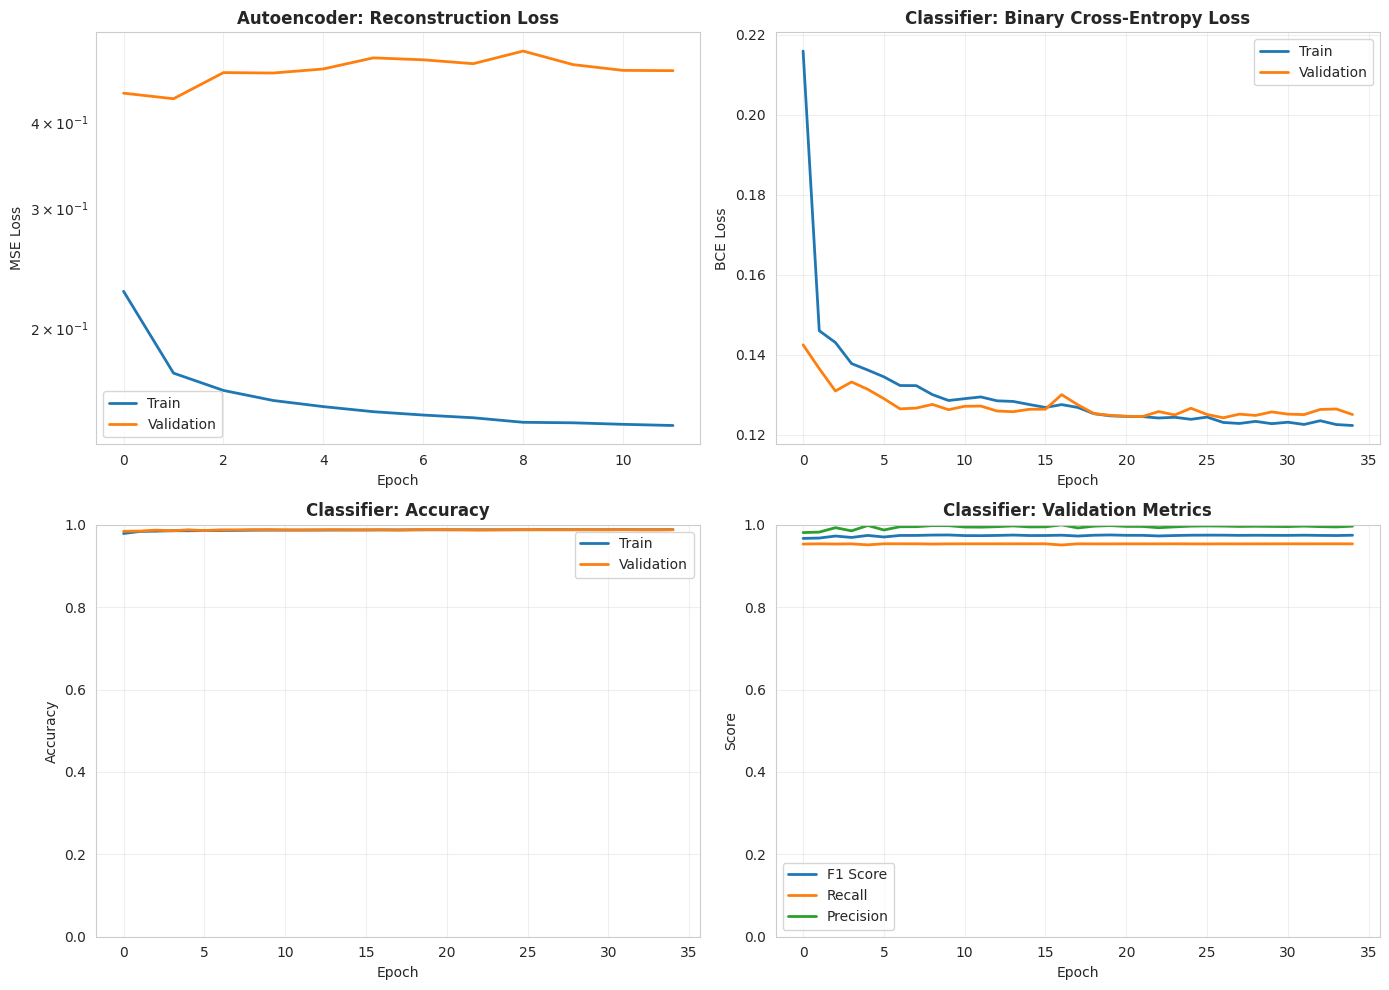


✓ Training histories plotted and saved


In [79]:
# Plot training histories
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Autoencoder loss
ax = axes[0, 0]
ax.plot(ae_history['train_loss'], label='Train', linewidth=2)
ax.plot(ae_history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Autoencoder: Reconstruction Loss', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_yscale('log')

# Classifier loss
ax = axes[0, 1]
ax.plot(clf_history['train_loss'], label='Train', linewidth=2)
ax.plot(clf_history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
ax.set_title('Classifier: Binary Cross-Entropy Loss', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Classifier accuracy
ax = axes[1, 0]
ax.plot(clf_history['train_acc'], label='Train', linewidth=2)
ax.plot(clf_history['val_acc'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier: Accuracy', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

# Classifier F1, Recall, Precision
ax = axes[1, 1]
ax.plot(clf_history['val_f1'], label='F1 Score', linewidth=2)
ax.plot(clf_history['val_recall'], label='Recall', linewidth=2)
ax.plot(clf_history['val_precision'], label='Precision', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_title('Classifier: Validation Metrics', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('phase2_training_history_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Training histories plotted and saved")

## 4. Model Evaluation

### Evaluation Strategy:
1. **Autoencoder**: Compute reconstruction errors, find optimal threshold
2. **Classifier**: Evaluate predictions, optimize threshold for recall
3. **Hybrid**: Combine both scores with optimal alpha weighting
4. **Compare**: ROC curves, confusion matrices, Cohen's d

In [80]:
from sklearn.metrics import recall_score, precision_score

# Compute reconstruction errors for all sets
print("\n" + "=" * 70)
print("AUTOENCODER EVALUATION")
print("=" * 70)

def compute_reconstruction_error(model, X_data):
    """Compute MSE reconstruction error for each sample"""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_data).to(device)
        reconstructed = model(X_tensor)
        errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
        return errors.cpu().numpy()

# Compute errors
train_ae_errors = compute_reconstruction_error(autoencoder, X_train_scaled)
val_ae_errors = compute_reconstruction_error(autoencoder, X_val_scaled)
test_ae_errors = compute_reconstruction_error(autoencoder, X_test_scaled)

# Separate by class for validation set
val_clean_errors = val_ae_errors[y_val == 0]
val_cheat_errors = val_ae_errors[y_val == 1]

print(f"\nReconstruction Errors (Validation Set):")
print(f"  Clean players:")
print(f"    Mean: {val_clean_errors.mean():.6f}")
print(f"    Median: {np.median(val_clean_errors):.6f}")
print(f"    Std: {val_clean_errors.std():.6f}")
print(f"\n  Cheaters:")
print(f"    Mean: {val_cheat_errors.mean():.6f}")
print(f"    Median: {np.median(val_cheat_errors):.6f}")
print(f"    Std: {val_cheat_errors.std():.6f}")

# Cohen's d for separation
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group2.mean() - group1.mean()) / pooled_std if pooled_std > 0 else 0

ae_cohens_d = cohens_d(val_clean_errors, val_cheat_errors)
print(f"\nCohen's d: {ae_cohens_d:.3f}")
if ae_cohens_d > 0:
    print("✓ Positive Cohen's d: Cheaters have HIGHER reconstruction error (CORRECT!)")
else:
    print("⚠ Negative Cohen's d: Cheaters have LOWER reconstruction error (PROBLEM!)")

# Find optimal threshold using validation set (maximize recall at 90% precision)
print("\nFinding optimal threshold...")
percentiles = np.arange(70, 99, 1)
best_threshold = None
best_recall = 0

for p in percentiles:
    threshold = np.percentile(val_clean_errors, p)
    ae_preds = (val_ae_errors > threshold).astype(int)
    recall = recall_score(y_val, ae_preds, zero_division=0)
    precision = precision_score(y_val, ae_preds, zero_division=0)
    
    if precision >= 0.5 and recall > best_recall:  # At least 50% precision
        best_recall = recall
        best_threshold = threshold
        best_percentile = p

if best_threshold is None:
    best_threshold = np.percentile(val_clean_errors, 90)
    best_percentile = 90

print(f"\nOptimal threshold: {best_threshold:.6f} ({best_percentile}th percentile of clean errors)")

# Evaluate with optimal threshold
ae_val_preds = (val_ae_errors > best_threshold).astype(int)
ae_test_preds = (test_ae_errors > best_threshold).astype(int)

print(f"\nValidation Performance:")
print(f"  Accuracy: {accuracy_score(y_val, ae_val_preds):.3f}")
print(f"  Precision: {precision_score(y_val, ae_val_preds, zero_division=0):.3f}")
print(f"  Recall: {recall_score(y_val, ae_val_preds, zero_division=0):.3f}")
print(f"  F1: {f1_score(y_val, ae_val_preds, zero_division=0):.3f}")

# Normalize errors to 0-1 for hybrid system
ae_min = val_clean_errors.min()
ae_max = np.percentile(val_clean_errors, 99)
ae_train_scores = np.clip((train_ae_errors - ae_min) / (ae_max - ae_min + 1e-8), 0, 1)
ae_val_scores = np.clip((val_ae_errors - ae_min) / (ae_max - ae_min + 1e-8), 0, 1)
ae_test_scores = np.clip((test_ae_errors - ae_min) / (ae_max - ae_min + 1e-8), 0, 1)


AUTOENCODER EVALUATION

Reconstruction Errors (Validation Set):
  Clean players:
    Mean: 0.123332
    Median: 0.078712
    Std: 0.913405

  Cheaters:
    Mean: 1.411162
    Median: 0.952081
    Std: 2.597278

Cohen's d: 0.857
✓ Positive Cohen's d: Cheaters have HIGHER reconstruction error (CORRECT!)

Finding optimal threshold...

Optimal threshold: 0.121784 (72th percentile of clean errors)

Validation Performance:
  Accuracy: 0.766
  Precision: 0.507
  Recall: 0.910
  F1: 0.651


In [81]:
# Evaluate supervised classifier
print("\n" + "=" * 70)
print("CLASSIFIER EVALUATION")
print("=" * 70)

def get_classifier_predictions(model, X_data):
    """Get probabilities from classifier"""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_data).to(device)
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        return probs

# Get predictions
clf_train_probs = get_classifier_predictions(classifier, X_train_scaled)
clf_val_probs = get_classifier_predictions(classifier, X_val_scaled)
clf_test_probs = get_classifier_predictions(classifier, X_test_scaled)

# Find optimal threshold for recall (instead of F1)
print("\nOptimizing threshold for maximum recall at reasonable precision...")
thresholds_to_try = np.arange(0.1, 0.9, 0.05)
best_clf_threshold = 0.5
best_clf_recall = 0

print("\nThreshold | Precision | Recall | F1")
print("-" * 45)
for thresh in thresholds_to_try:
    preds = (clf_val_probs > thresh).astype(int)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds, zero_division=0)
    f1 = f1_score(y_val, preds, zero_division=0)
    print(f"  {thresh:.2f}   |   {prec:.3f}   |  {rec:.3f} | {f1:.3f}")
    
    # Want high recall with at least 50% precision
    if prec >= 0.5 and rec > best_clf_recall:
        best_clf_recall = rec
        best_clf_threshold = thresh

print(f"\nOptimal threshold: {best_clf_threshold:.2f}")
print(f"  Achieves {best_clf_recall:.1%} recall")

# Make predictions with optimal threshold
clf_val_preds = (clf_val_probs > best_clf_threshold).astype(int)
clf_test_preds = (clf_test_probs > best_clf_threshold).astype(int)

print(f"\nValidation Performance (threshold={best_clf_threshold:.2f}):")
print(f"  Accuracy: {accuracy_score(y_val, clf_val_preds):.3f}")
print(f"  Precision: {precision_score(y_val, clf_val_preds, zero_division=0):.3f}")
print(f"  Recall: {recall_score(y_val, clf_val_preds, zero_division=0):.3f}")
print(f"  F1: {f1_score(y_val, clf_val_preds, zero_division=0):.3f}")

# Separate clean vs cheater scores
val_clean_clf_scores = clf_val_probs[y_val == 0]
val_cheat_clf_scores = clf_val_probs[y_val == 1]

clf_cohens_d = cohens_d(val_clean_clf_scores, val_cheat_clf_scores)
print(f"\nCohen's d: {clf_cohens_d:.3f}")
if clf_cohens_d > 0.8:
    print("✓ Good separation between classes")


CLASSIFIER EVALUATION

Optimizing threshold for maximum recall at reasonable precision...

Threshold | Precision | Recall | F1
---------------------------------------------
  0.10   |   0.747   |  0.969 | 0.844
  0.15   |   0.990   |  0.954 | 0.972
  0.20   |   0.994   |  0.954 | 0.974
  0.25   |   0.996   |  0.954 | 0.974
  0.30   |   0.996   |  0.954 | 0.975
  0.35   |   0.997   |  0.954 | 0.975
  0.40   |   0.997   |  0.954 | 0.975
  0.45   |   0.998   |  0.954 | 0.975
  0.50   |   0.998   |  0.954 | 0.975
  0.55   |   0.998   |  0.954 | 0.975
  0.60   |   0.999   |  0.954 | 0.976
  0.65   |   0.999   |  0.953 | 0.976
  0.70   |   0.999   |  0.953 | 0.976
  0.75   |   1.000   |  0.953 | 0.976
  0.80   |   1.000   |  0.952 | 0.975
  0.85   |   1.000   |  0.951 | 0.975

Optimal threshold: 0.10
  Achieves 96.9% recall

Validation Performance (threshold=0.10):
  Accuracy: 0.914
  Precision: 0.747
  Recall: 0.969
  F1: 0.844

Cohen's d: 8.962
✓ Good separation between classes


In [82]:
# Create hybrid system with optimal alpha
print("\n" + "=" * 70)
print("HYBRID SYSTEM OPTIMIZATION")
print("=" * 70)

# Try different alpha values
alphas_to_try = np.arange(0, 1.1, 0.1)
best_alpha = 0.5
best_hybrid_f1 = 0
best_hybrid_recall = 0

print("\nAlpha | AUC   | F1    | Recall | Precision")
print("-" * 50)

alpha_results = []
for alpha in alphas_to_try:
    # Hybrid score: alpha * classifier + (1-alpha) * autoencoder
    hybrid_val_scores = alpha * clf_val_probs + (1 - alpha) * ae_val_scores
    
    # Calculate AUC
    auc = roc_auc_score(y_val, hybrid_val_scores)
    
    # Find best threshold for this alpha
    best_thresh = 0.5
    best_f1_for_alpha = 0
    for thresh in np.arange(0.3, 0.8, 0.05):
        preds = (hybrid_val_scores > thresh).astype(int)
        f1 = f1_score(y_val, preds, zero_division=0)
        if f1 > best_f1_for_alpha:
            best_f1_for_alpha = f1
            best_thresh = thresh
    
    # Evaluate with best threshold
    preds = (hybrid_val_scores > best_thresh).astype(int)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds, zero_division=0)
    
    alpha_results.append({
        'alpha': alpha,
        'auc': auc,
        'f1': best_f1_for_alpha,
        'recall': rec,
        'precision': prec,
        'threshold': best_thresh
    })
    
    print(f" {alpha:.1f}  | {auc:.3f} | {best_f1_for_alpha:.3f} | {rec:.3f}  |  {prec:.3f}")
    
    # Track best alpha based on F1 score
    if best_f1_for_alpha > best_hybrid_f1:
        best_hybrid_f1 = best_f1_for_alpha
        best_hybrid_recall = rec
        best_alpha = alpha
        best_hybrid_threshold = best_thresh

print(f"\n✓ Optimal alpha: {best_alpha:.1f}")
print(f"  Classifier weight: {best_alpha:.1%}")
print(f"  Autoencoder weight: {(1-best_alpha):.1%}")
print(f"  Best F1: {best_hybrid_f1:.3f}")
print(f"  Best Recall: {best_hybrid_recall:.3f}")
print(f"  Optimal threshold: {best_hybrid_threshold:.2f}")

# Generate final hybrid predictions
hybrid_train_scores = best_alpha * clf_train_probs + (1 - best_alpha) * ae_train_scores
hybrid_val_scores = best_alpha * clf_val_probs + (1 - best_alpha) * ae_val_scores
hybrid_test_scores = best_alpha * clf_test_probs + (1 - best_alpha) * ae_test_scores

hybrid_val_preds = (hybrid_val_scores > best_hybrid_threshold).astype(int)
hybrid_test_preds = (hybrid_test_scores > best_hybrid_threshold).astype(int)


HYBRID SYSTEM OPTIMIZATION

Alpha | AUC   | F1    | Recall | Precision
--------------------------------------------------
 0.0  | 0.929 | 0.795 | 0.752  |  0.843
 0.1  | 0.956 | 0.818 | 0.789  |  0.850
 0.2  | 0.970 | 0.850 | 0.871  |  0.830
 0.3  | 0.977 | 0.896 | 0.924  |  0.870
 0.4  | 0.981 | 0.928 | 0.944  |  0.913
 0.5  | 0.985 | 0.967 | 0.937  |  0.998
 0.6  | 0.986 | 0.976 | 0.953  |  1.000
 0.7  | 0.987 | 0.976 | 0.954  |  0.999
 0.8  | 0.988 | 0.976 | 0.954  |  0.999
 0.9  | 0.990 | 0.976 | 0.954  |  0.999
 1.0  | 0.990 | 0.976 | 0.954  |  0.999

✓ Optimal alpha: 0.7
  Classifier weight: 70.0%
  Autoencoder weight: 30.0%
  Best F1: 0.976
  Best Recall: 0.954
  Optimal threshold: 0.45


In [83]:
# Final test set evaluation
print("\n" + "=" * 70)
print("FINAL TEST SET EVALUATION")
print("=" * 70)

# Compute metrics for all three approaches
approaches = {
    'Autoencoder': (ae_test_scores, ae_test_preds),
    'Classifier': (clf_test_probs, clf_test_preds),
    'Hybrid': (hybrid_test_scores, hybrid_test_preds)
}

results_summary = []

for name, (scores, preds) in approaches.items():
    auc = roc_auc_score(y_test, scores)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    
    # Cohen's d
    clean_scores = scores[y_test == 0]
    cheat_scores = scores[y_test == 1]
    d = cohens_d(clean_scores, cheat_scores)
    
    results_summary.append({
        'Approach': name,
        'AUC': auc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'Cohen_d': d
    })
    
    print(f"\n{name}:")
    print(f"  AUC:       {auc:.3f}")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1 Score:  {f1:.3f}")
    print(f"  Cohen's d: {d:.3f}")

# Create comparison DataFrame
results_df = pd.DataFrame(results_summary)
print("\n" + "=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)
print(results_df.to_string(index=False))

# Highlight best performer
best_auc = results_df.loc[results_df['AUC'].idxmax(), 'Approach']
best_recall = results_df.loc[results_df['Recall'].idxmax(), 'Approach']
best_f1 = results_df.loc[results_df['F1'].idxmax(), 'Approach']

print(f"\n✓ Best AUC: {best_auc}")
print(f"✓ Best Recall: {best_recall}")
print(f"✓ Best F1: {best_f1}")


FINAL TEST SET EVALUATION

Autoencoder:
  AUC:       0.931
  Accuracy:  0.767
  Precision: 0.509
  Recall:    0.913
  F1 Score:  0.654
  Cohen's d: 2.815

Classifier:
  AUC:       0.990
  Accuracy:  0.914
  Precision: 0.749
  Recall:    0.968
  F1 Score:  0.844
  Cohen's d: 8.998

Hybrid:
  AUC:       0.987
  Accuracy:  0.989
  Precision: 0.999
  Recall:    0.954
  F1 Score:  0.976
  Cohen's d: 7.505

PERFORMANCE COMPARISON
   Approach      AUC  Accuracy  Precision   Recall       F1  Cohen_d
Autoencoder 0.930617  0.767348   0.509204 0.913358 0.653870 2.815225
 Classifier 0.990027  0.914203   0.748769 0.968278 0.844493 8.997789
     Hybrid 0.987367  0.988681   0.998532 0.954359 0.975946 7.505167

✓ Best AUC: Classifier
✓ Best Recall: Classifier
✓ Best F1: Hybrid



PLOTTING ROC CURVES


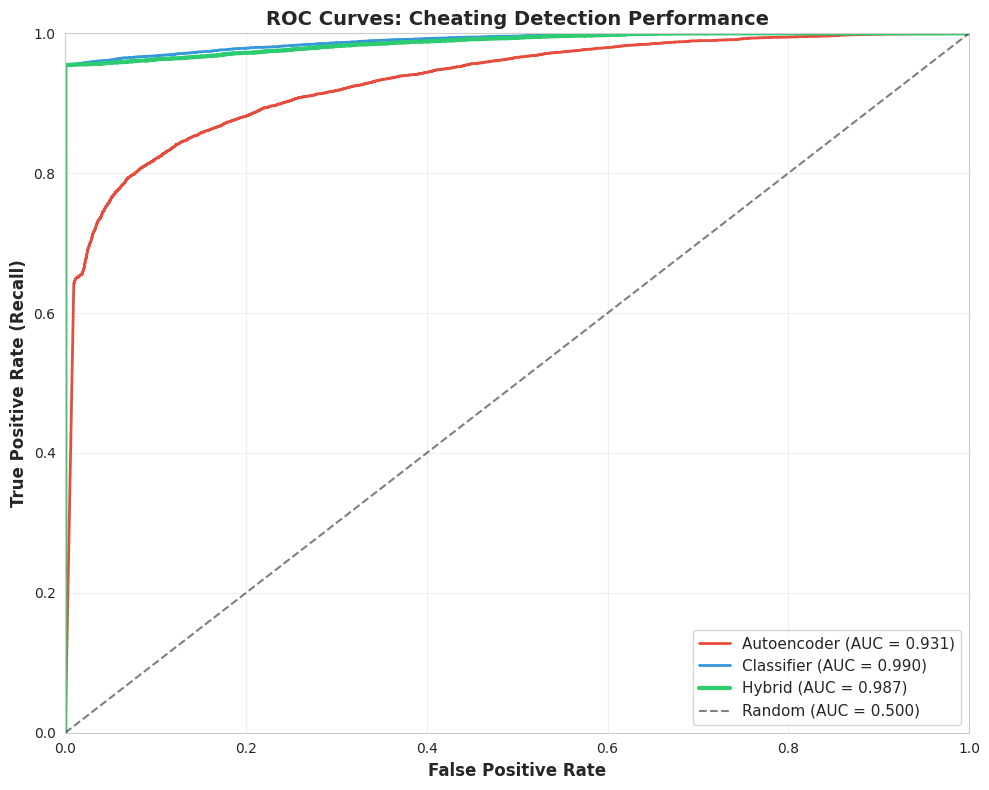

✓ ROC curves saved to 'phase2_roc_curves_v2.png'


In [84]:
# Plot ROC curves
print("\n" + "=" * 70)
print("PLOTTING ROC CURVES")
print("=" * 70)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = {'Autoencoder': '#E74C3C', 'Classifier': '#3498DB', 'Hybrid': '#2ECC71'}
linewidths = {'Autoencoder': 2, 'Classifier': 2, 'Hybrid': 3}

for name, (scores, _) in approaches.items():
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    ax.plot(fpr, tpr, 
            label=f'{name} (AUC = {auc:.3f})', 
            linewidth=linewidths[name],
            color=colors[name])

# Random baseline
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random (AUC = 0.500)', alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Cheating Detection Performance', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('phase2_roc_curves_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved to 'phase2_roc_curves_v2.png'")


PLOTTING CONFUSION MATRICES


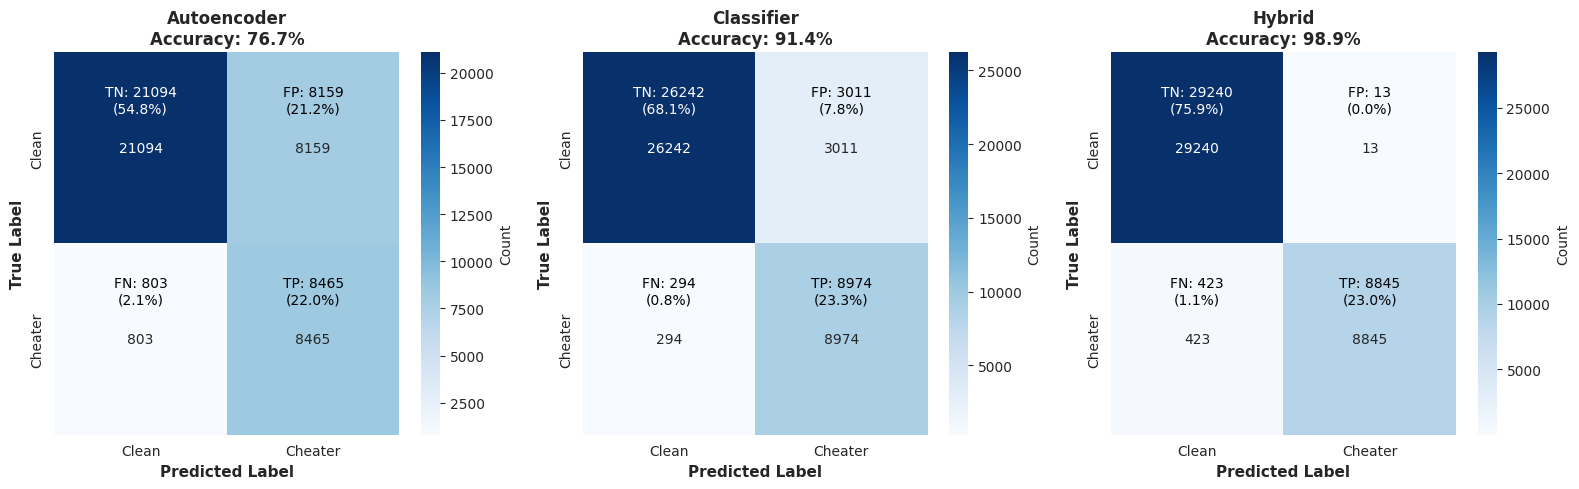

✓ Confusion matrices saved to 'phase2_confusion_matrices_v2.png'


In [85]:
# Plot confusion matrices
print("\n" + "=" * 70)
print("PLOTTING CONFUSION MATRICES")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, (scores, preds)) in enumerate(approaches.items()):
    ax = axes[idx]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, preds)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Clean', 'Cheater'],
                yticklabels=['Clean', 'Cheater'],
                cbar_kws={'label': 'Count'})
    
    # Calculate percentages
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_test, preds):.1%}', 
                 fontsize=12, fontweight='bold')
    
    # Add text annotations with percentages
    ax.text(0.5, 0.25, f'TN: {tn}\n({tn/total:.1%})', 
            ha='center', va='center', fontsize=10, color='white' if tn > total/4 else 'black')
    ax.text(1.5, 0.25, f'FP: {fp}\n({fp/total:.1%})', 
            ha='center', va='center', fontsize=10, color='white' if fp > total/4 else 'black')
    ax.text(0.5, 1.25, f'FN: {fn}\n({fn/total:.1%})', 
            ha='center', va='center', fontsize=10, color='white' if fn > total/4 else 'black')
    ax.text(1.5, 1.25, f'TP: {tp}\n({tp/total:.1%})', 
            ha='center', va='center', fontsize=10, color='white' if tp > total/4 else 'black')

plt.tight_layout()
plt.savefig('phase2_confusion_matrices_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved to 'phase2_confusion_matrices_v2.png'")

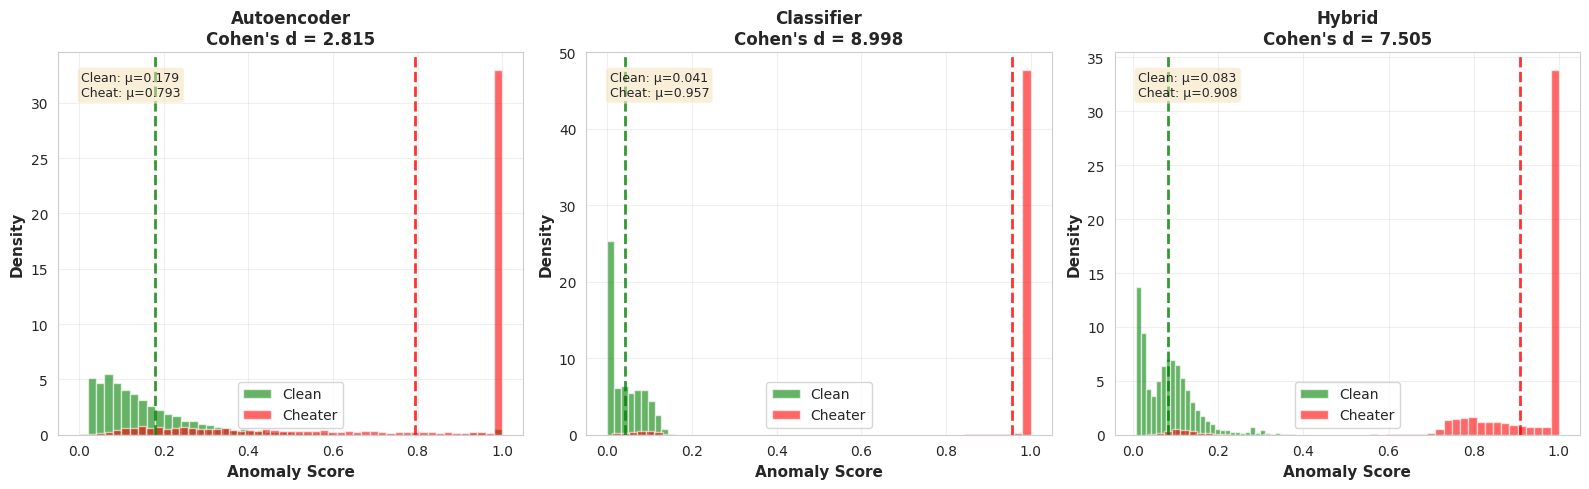

✓ Score distributions saved to 'phase2_score_distributions_v2.png'


In [86]:
# Plot score distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, (scores, _)) in enumerate(approaches.items()):
    ax = axes[idx]
    
    clean_scores = scores[y_test == 0]
    cheat_scores = scores[y_test == 1]
    
    # Plot distributions
    ax.hist(clean_scores, bins=50, alpha=0.6, label='Clean', color='green', density=True)
    ax.hist(cheat_scores, bins=50, alpha=0.6, label='Cheater', color='red', density=True)
    
    # Add mean lines
    ax.axvline(clean_scores.mean(), color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax.axvline(cheat_scores.mean(), color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    # Cohen's d
    d = cohens_d(clean_scores, cheat_scores)
    
    ax.set_xlabel('Anomaly Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f"{name}\nCohen's d = {d:.3f}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    # Add text box with statistics
    textstr = f'Clean: μ={clean_scores.mean():.3f}\nCheat: μ={cheat_scores.mean():.3f}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('phase2_score_distributions_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Score distributions saved to 'phase2_score_distributions_v2.png'")

In [87]:
# Save all results
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save results to file
np.savez('phase2_anomaly_results_v2.npz',
    # Test set results
    y_test=y_test,
    ae_test_scores=ae_test_scores,
    ae_test_preds=ae_test_preds,
    clf_test_probs=clf_test_probs,
    clf_test_preds=clf_test_preds,
    hybrid_test_scores=hybrid_test_scores,
    hybrid_test_preds=hybrid_test_preds,
    # Hyperparameters
    best_alpha=best_alpha,
    best_hybrid_threshold=best_hybrid_threshold,
    best_clf_threshold=best_clf_threshold,
    ae_threshold=best_threshold,
    # Scaler
    scaler_mean=scaler.mean_,
    scaler_scale=scaler.scale_,
    # Feature names
    feature_names=feature_columns
)

print("✓ Results saved to 'phase2_anomaly_results_v2.npz'")

# Save performance summary
results_df.to_csv('phase2_performance_summary_v2.csv', index=False)
print("✓ Performance summary saved to 'phase2_performance_summary_v2.csv'")

# Print file summary
print("\nSaved files:")
print("  - best_autoencoder_v2.pt")
print("  - best_classifier_v2.pt")
print("  - phase2_anomaly_results_v2.npz")
print("  - phase2_performance_summary_v2.csv")
print("  - phase2_training_history_v2.png")
print("  - phase2_roc_curves_v2.png")
print("  - phase2_confusion_matrices_v2.png")
print("  - phase2_score_distributions_v2.png")
print("  - spotting_cheaters_features.png")


SAVING RESULTS
✓ Results saved to 'phase2_anomaly_results_v2.npz'
✓ Performance summary saved to 'phase2_performance_summary_v2.csv'

Saved files:
  - best_autoencoder_v2.pt
  - best_classifier_v2.pt
  - phase2_anomaly_results_v2.npz
  - phase2_performance_summary_v2.csv
  - phase2_training_history_v2.png
  - phase2_roc_curves_v2.png
  - phase2_confusion_matrices_v2.png
  - phase2_score_distributions_v2.png
  - spotting_cheaters_features.png
